## Step 1: Setup and Imports

In [39]:
# Import packages
import os
import zipfile
import subprocess
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shutil
from tqdm import tqdm


from Bio import SeqIO
from collections import Counter

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, log_loss

# Errors ignore
import warnings
warnings.filterwarnings('ignore')

## Step 2: Load Metadata

In [3]:
train_df = pd.read_csv("Train.csv")
test_df = pd.read_csv("Test.csv")
train_subjects_df = pd.read_csv("Train_Subjects.csv")
submission = pd.read_csv("SampleSubmission.csv")

## Step 3: Data Exploration

In [5]:
%%time

print("Train dataframe shape: ", train_df.shape)
print("Test dataframe shape: ", test_df.shape)
print("Train subjects dataframe shape: ", train_subjects_df.shape)
print(train_df.head())

Train dataframe shape:  (2901, 4)
Test dataframe shape:  (1068, 1)
Train subjects dataframe shape:  (66, 17)
        filename SampleType       SubjectID       SampleID
0  ID_LETPJN.mgb      Stool  Subject_BCUNIB  Sample_AFTIWE
1  ID_NTDGIW.mgb      Stool  Subject_UDAXIH  Sample_JQJVNK
2  ID_ZISBMF.mgb      Nasal  Subject_VRKADI  Sample_YJWGWW
3  ID_MDCVXU.mgb      Nasal  Subject_HIFZWD  Sample_VKEHZP
4  ID_SWAMNY.mgb      Stool  Subject_VGLNCV  Sample_NTDTEQ
CPU times: total: 15.6 ms
Wall time: 23.3 ms


In [8]:
# Check for missing Fastq files

fastq_files = os.listdir(os.getcwd() + "/FastqTrain")
train_fastq_ids = set(f.replace(".fastq", "") for f in fastq_files)

train_df['filename'] = train_df['filename'].str.replace(".mgb", "", regex=False)

missing_files = set(train_df['filename']) - train_fastq_ids
print(f"Missing fastq files for {len(missing_files)} train enteries")

Missing fastq files for 0 train enteries


Unique Sample Types: ['Stool' 'Nasal' 'Mouth' 'Skin']
Samples per Subject:
 SubjectID
Subject_UDAXIH    441
Subject_HBHSCC    159
Subject_CHDMIO    138
Subject_ASRHSH    111
Subject_VGLNCV    105
                 ... 
Subject_AYZFWN      6
Subject_VNLNNO      5
Subject_CBVHYJ      5
Subject_TGELYF      3
Subject_KIEGYK      1
Name: count, Length: 66, dtype: int64


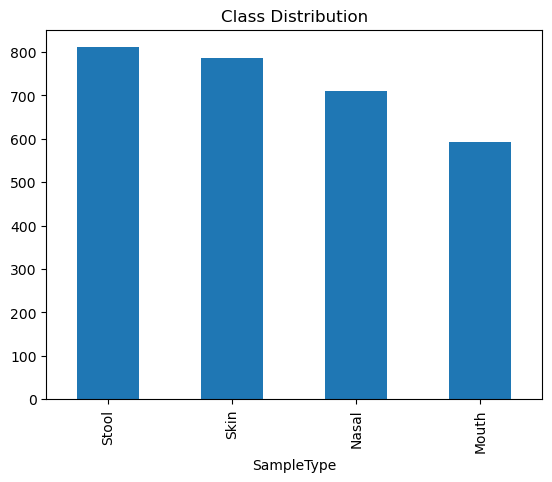

In [ ]:
print("Unique Sample Types:", train_df['SampleType'].unique())
print("Samples per Subject:\n", train_df['SubjectID'].value_counts().head())

# View Distribution of sample types
train_df["SampleType"].value_counts().plot(kind='bar', title='Class Distribution')
plt.show()

## Step 4: Feature Extraction

In [9]:
def extract_kmers(seq, k):
    return [seq[i:i+k] for i in range(len(seq) - k + 1)]

def extract_features_from_fastq(path, k=3):
    read_lengths = []
    gc_counts = []
    nt_counter = Counter()
    kmer_counter = Counter()

    for record in SeqIO.parse(path, "fastq"):
        seq = str(record.seq)
        read_lengths.append(len(seq))
        gc_counts.append(seq.count("G") + seq.count("C"))
        nt_counter.update(seq)
        kmer_counter.update(extract_kmers(seq, k))

    if not read_lengths:
        return None

    total_len = sum(read_lengths)
    total_kmers = sum(kmer_counter.values())
    kmer_freqs = {f'kmer_{kmer}': count / total_kmers for kmer, count in kmer_counter.items()}

    return {
        "num_reads": len(read_lengths),
        "avg_read_len": total_len / len(read_lengths),
        "gc_content": sum(gc_counts) / total_len,
        "A": nt_counter["A"] / total_len,
        "T": nt_counter["T"] / total_len,
        "G": nt_counter["G"] / total_len,
        "C": nt_counter["C"] / total_len,
        **kmer_freqs
    }


## Step 5: Process Training Files

In [34]:
train_dir = os.path.join(os.getcwd(), "FastqTrain")
output_csv = "full_train.csv"

# Load previously saved features (if resuming)
train_features = []
if os.path.exists(output_csv):
    df_existing = pd.read_csv(output_csv)
    train_features = df_existing.to_dict("records")
    print(f"✅ Resuming from {len(train_features)} previously processed files.")

processed_files = set(f["filename"] for f in train_features)

# Begin loop
for i, (_, row) in enumerate(tqdm(train_df.iterrows(), total=len(train_df), desc="Processing Files..")):
    filename_base = row["filename"].replace(".mgb", "").strip()
    if filename_base in processed_files:
        continue

    
    filename = filename_base + ".fastq"
    fpath = os.path.join(train_dir, filename)

    if not os.path.exists(fpath):
        print(f"⚠️ File not found: {fpath}")
        continue

    features = extract_features_from_fastq(fpath, k=3)
    if features:
        features["filename"] = row["filename"]
        features["label"] = row["SampleType"]
        train_features.append(features)

    # 🔁 Save every 50 files
    if len(train_features) % 50 == 0:
        pd.DataFrame(train_features).to_csv(output_csv, index=False)
        print(f"💾 Progress saved: {len(train_features)} rows")

# Final save
pd.DataFrame(train_features).to_csv(output_csv, index=False)
print("✅ Feature extraction complete and saved.")

✅ Resuming from 2261 previously processed files.


Processing Files..:  79%|███████▉  | 2298/2901 [23:03<2:11:52, 13.12s/it]  

💾 Progress saved: 2300 rows


Processing Files..:  81%|████████  | 2350/2901 [43:53<3:52:58, 25.37s/it]

💾 Progress saved: 2350 rows


Processing Files..:  83%|████████▎ | 2400/2901 [1:13:07<1:44:10, 12.48s/it]  

💾 Progress saved: 2400 rows


Processing Files..:  84%|████████▍ | 2450/2901 [1:26:33<2:50:39, 22.70s/it]

💾 Progress saved: 2450 rows


Processing Files..:  86%|████████▌ | 2500/2901 [2:01:24<7:30:47, 67.45s/it]  

💾 Progress saved: 2500 rows


Processing Files..:  88%|████████▊ | 2550/2901 [2:16:03<41:43,  7.13s/it]  

💾 Progress saved: 2550 rows


Processing Files..:  90%|████████▉ | 2600/2901 [2:26:50<32:03,  6.39s/it]  

💾 Progress saved: 2600 rows


Processing Files..:  91%|█████████▏| 2650/2901 [2:39:05<52:16, 12.50s/it]  

💾 Progress saved: 2650 rows


Processing Files..:  93%|█████████▎| 2700/2901 [2:51:34<1:16:52, 22.95s/it]

💾 Progress saved: 2700 rows


Processing Files..:  95%|█████████▍| 2750/2901 [3:04:01<38:42, 15.38s/it]  

💾 Progress saved: 2750 rows


Processing Files..:  97%|█████████▋| 2800/2901 [3:12:13<09:01,  5.36s/it]

💾 Progress saved: 2800 rows


Processing Files..:  98%|█████████▊| 2850/2901 [3:25:12<14:10, 16.68s/it]

💾 Progress saved: 2850 rows


Processing Files..: 100%|█████████▉| 2900/2901 [3:38:59<00:23, 23.86s/it]

💾 Progress saved: 2900 rows


Processing Files..: 100%|██████████| 2901/2901 [3:39:30<00:00,  4.54s/it]


✅ Feature extraction complete and saved.


In [35]:
df_train = pd.read_csv("full_train.csv")
df_train.head()

,num_reads,avg_read_len,gc_content,A,T,G,C,kmer_GGA,kmer_GAT,kmer_ATG,...,kmer_AAT,kmer_TCT,kmer_CTC,kmer_ATT,kmer_TGT,kmer_GTT,kmer_TCA,kmer_TTC,filename,label
0,21599,400.0,0.528146,0.279865,0.191989,0.305681,0.222465,0.026204,0.026770,0.019927,...,0.010701,0.011834,0.006010,0.013776,0.002722,0.006606,0.005627,0.005824,ID_LETPJN,Stool
1,20295,400.0,0.535742,0.268719,0.195539,0.314609,0.221133,0.025630,0.023874,0.022925,...,0.010015,0.006595,0.006637,0.014765,0.003153,0.009429,0.005155,0.008712,ID_NTDGIW,Stool
2,16449,400.0,0.551703,0.249779,0.198518,0.330586,0.221118,0.029535,0.020455,0.017627,...,0.012303,0.005564,0.008142,0.007227,0.006012,0.009209,0.004913,0.006815,ID_ZISBMF,Nasal
3,36965,400.0,0.545204,0.253585,0.201211,0.324064,0.221141,0.029429,0.022367,0.018166,...,0.011701,0.010337,0.005967,0.005237,0.007862,0.008219,0.004289,0.009077,ID_MDCVXU,Nasal
4,40236,400.0,0.537097,0.267547,0.195356,0.312494,0.224603,0.026121,0.024074,0.024539,...,0.010222,0.008023,0.006160,0.014174,0.003382,0.009457,0.005427,0.010273,ID_SWAMNY,Stool


## Step 6: Label Encoding

In [36]:

le = LabelEncoder()
df_train["label_enc"] = le.fit_transform(df_train["label"])

## Step 7: Train/Test Split and Modeling

In [40]:
X = df_train.drop(columns=["filename", "label", "label_enc"])
y = df_train["label_enc"]

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold = 1
accuracies = []
losses = []

for train_index, val_index in skf.split(X, y):
    print(f"\n Fold {fold}")

    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_val)
    y_proba = clf.predict_proba(X_val)

    accuracy = accuracy_score(y_val, y_pred)
    loss = log_loss(y_val, y_proba)

    accuracies.append(accuracy)
    losses.append(loss)

    print(f"✅ Fold {fold} Accuracy: {accuracy:.4f}")
    print(f"📉 Fold {fold} Log Loss: {loss:.4f}")
    print(classification_report(y_val, y_pred, target_names=le.classes_))

    fold += 1

print(f"\n📊 Average Accuracy: {np.mean(accuracies):.4f}")
print(f"📉 Average Log Loss: {np.mean(losses):.4f}")



 Fold 1
✅ Fold 1 Accuracy: 0.9914
📉 Fold 1 Log Loss: 0.0461
              precision    recall  f1-score   support

       Mouth       0.97      0.99      0.98       118
       Nasal       1.00      0.99      1.00       142
        Skin       0.99      0.98      0.99       158
       Stool       0.99      1.00      1.00       163

    accuracy                           0.99       581
   macro avg       0.99      0.99      0.99       581
weighted avg       0.99      0.99      0.99       581


 Fold 2
✅ Fold 2 Accuracy: 0.9931
📉 Fold 2 Log Loss: 0.0337
              precision    recall  f1-score   support

       Mouth       0.99      0.99      0.99       119
       Nasal       1.00      0.99      0.99       142
        Skin       0.99      0.99      0.99       157
       Stool       0.99      1.00      0.99       162

    accuracy                           0.99       580
   macro avg       0.99      0.99      0.99       580
weighted avg       0.99      0.99      0.99       580


 Fold 3

## Step 8: Process Test Files and Predict

In [41]:
# Define inputs
feature_cols = X.columns.tolist()
test_dir = os.path.join(os.getcwd(), "FastqTest")
output_csv = "test_features.csv"

# Load previously saved features (for resume)
test_features = []
if os.path.exists(output_csv):
    df_existing = pd.read_csv(output_csv)
    test_features = df_existing.to_dict("records")
    processed_files = set(f["filename"] for f in test_features)
    print(f"✅ Resuming from {len(processed_files)} previously processed test files.")
else:
    processed_files = set()

# Process test files
all_files = [f for f in os.listdir(test_dir) if f.endswith(".fastq")]
for fname in tqdm(all_files, desc="Processing test files", total=len(all_files)):
    base_name = os.path.splitext(fname)[0]

    if base_name in processed_files:
        continue  # ✅ Skip already processed files

    fpath = os.path.join(test_dir, fname)
    if not os.path.exists(fpath):
        print(f"⚠️ File not found: {fpath}")
        continue

    try:
        features = extract_features_from_fastq(fpath, k=3)
    except Exception as e:
        print(f"❌ Error processing {fname}: {e}")
        continue

    if features:
        # Ensure all expected features are included
        for col in feature_cols:
            if col not in features:
                features[col] = 0.0

        # Retain only expected features
        features = {col: features[col] for col in feature_cols}
        features["filename"] = base_name
        test_features.append(features)

    # Save progress every 50 files
    if len(test_features) % 50 == 0:
        pd.DataFrame(test_features).to_csv(output_csv, index=False)
        print(f"💾 Progress saved at {len(test_features)} files")

# Final save
df_test = pd.DataFrame(test_features)
df_test.to_csv(output_csv, index=False)
print("✅ Test feature extraction complete and saved to:", output_csv)


Processing test files:   5%|▍         | 50/1068 [07:21<3:23:41, 12.01s/it]

💾 Progress saved at 50 files


Processing test files:   9%|▉         | 100/1068 [14:01<2:22:18,  8.82s/it]

💾 Progress saved at 100 files


Processing test files:  14%|█▍        | 150/1068 [21:50<1:33:33,  6.12s/it]

💾 Progress saved at 150 files


Processing test files:  19%|█▊        | 200/1068 [30:58<3:16:30, 13.58s/it]

💾 Progress saved at 200 files


Processing test files:  23%|██▎       | 250/1068 [36:19<53:08,  3.90s/it]  

💾 Progress saved at 250 files


Processing test files:  28%|██▊       | 300/1068 [44:54<3:51:50, 18.11s/it]

💾 Progress saved at 300 files


Processing test files:  33%|███▎      | 351/1068 [54:05<1:02:16,  5.21s/it]

💾 Progress saved at 350 files


Processing test files:  37%|███▋      | 400/1068 [1:02:35<1:54:06, 10.25s/it]

💾 Progress saved at 400 files


Processing test files:  42%|████▏     | 450/1068 [1:14:26<55:50,  5.42s/it]   

💾 Progress saved at 450 files


Processing test files:  47%|████▋     | 500/1068 [1:21:35<1:26:21,  9.12s/it]

💾 Progress saved at 500 files


Processing test files:  51%|█████▏    | 550/1068 [1:27:20<27:40,  3.21s/it]  

💾 Progress saved at 550 files


Processing test files:  56%|█████▌    | 600/1068 [1:35:40<48:39,  6.24s/it]  

💾 Progress saved at 600 files


Processing test files:  61%|██████    | 650/1068 [1:43:35<2:14:22, 19.29s/it]

💾 Progress saved at 650 files


Processing test files:  66%|██████▌   | 700/1068 [1:51:21<40:10,  6.55s/it]  

💾 Progress saved at 700 files


Processing test files:  70%|███████   | 750/1068 [1:57:34<1:51:52, 21.11s/it]

💾 Progress saved at 750 files


Processing test files:  75%|███████▍  | 800/1068 [2:06:10<2:40:42, 35.98s/it]

💾 Progress saved at 800 files


Processing test files:  80%|███████▉  | 850/1068 [2:13:45<38:58, 10.73s/it]  

💾 Progress saved at 850 files


Processing test files:  84%|████████▍ | 900/1068 [2:22:36<30:40, 10.96s/it]  

💾 Progress saved at 900 files


Processing test files:  89%|████████▉ | 950/1068 [2:30:15<08:35,  4.37s/it]

💾 Progress saved at 950 files


Processing test files:  94%|█████████▎| 1000/1068 [2:39:33<10:06,  8.91s/it]

💾 Progress saved at 1000 files


Processing test files:  98%|█████████▊| 1050/1068 [2:45:29<01:34,  5.24s/it]

💾 Progress saved at 1050 files


Processing test files: 100%|██████████| 1068/1068 [2:47:19<00:00,  9.40s/it]


✅ Test feature extraction complete and saved to: test_features.csv


In [42]:
df_test = pd.read_csv("test_features.csv")
print("Test features:", df_test.columns.tolist())
print("Train features:", X.columns.tolist())

Test features: ['num_reads', 'avg_read_len', 'gc_content', 'A', 'T', 'G', 'C', 'kmer_GGA', 'kmer_GAT', 'kmer_ATG', 'kmer_TGA', 'kmer_GAA', 'kmer_AAC', 'kmer_ACG', 'kmer_CGC', 'kmer_GCT', 'kmer_CTA', 'kmer_TAG', 'kmer_AGC', 'kmer_TAC', 'kmer_ACA', 'kmer_CAG', 'kmer_AGG', 'kmer_GGC', 'kmer_CTT', 'kmer_TTA', 'kmer_TAA', 'kmer_CAC', 'kmer_CAT', 'kmer_TGC', 'kmer_GCA', 'kmer_CAA', 'kmer_AAG', 'kmer_AGT', 'kmer_GTC', 'kmer_TCG', 'kmer_CGA', 'kmer_GAG', 'kmer_GGG', 'kmer_AAA', 'kmer_GAC', 'kmer_ATC', 'kmer_TTG', 'kmer_TTT', 'kmer_TGG', 'kmer_GCG', 'kmer_CGT', 'kmer_ACC', 'kmer_CCG', 'kmer_CGG', 'kmer_GGT', 'kmer_GTG', 'kmer_GTA', 'kmer_TAT', 'kmer_TCC', 'kmer_CCA', 'kmer_CCT', 'kmer_CTG', 'kmer_GCC', 'kmer_CCC', 'kmer_ACT', 'kmer_ATA', 'kmer_AGA', 'kmer_AAT', 'kmer_TCT', 'kmer_CTC', 'kmer_ATT', 'kmer_TGT', 'kmer_GTT', 'kmer_TCA', 'kmer_TTC', 'filename']
Train features: ['num_reads', 'avg_read_len', 'gc_content', 'A', 'T', 'G', 'C', 'kmer_GGA', 'kmer_GAT', 'kmer_ATG', 'kmer_TGA', 'kmer_GAA', '

In [43]:
X_test = df_test.drop(columns=["filename"])
probs = clf.predict_proba(X_test)

## Step 9: Create Submission File

In [44]:
probs_df = pd.DataFrame(probs, columns=le.inverse_transform(clf.classes_))
probs_df.insert(0, "filename", df_test["filename"])

# Ensure all columns exist
for col in ["Mouth", "Nasal", "Skin", "Stool"]:
    if col not in probs_df.columns:
        probs_df[col] = 0.0

# Ordering
probs_df = probs_df[["filename", "Mouth", "Nasal", "Skin", "Stool"]]
probs_df.to_csv("submission.csv", index=False)